<a href="https://www.nvidia.com/dli/"> <img src="https://developer.download.nvidia.com/training/images/DLI%20Header.png" alt="Header" style="width: 400px;"/> </a>

# The Necessity of Explainability

Due to the success of Artificial Intelligence, it is used in a diverse range of applications, from song selection to self-driving cars. Depending on the task, an incorrect decision made by the AI may have unpleasant or even deadly consequences. Consider, for instance, the tragedy in March 2018 where an Uber self-driving car failed to recognize a pedestrian crossing the street.

This raises some questions. Who is at fault when an AI system makes a mistake? How can these mistakes be predicted and avoided? And how can the AI be troubleshot and repaired?

Unfortunately, it is difficult to understand what AI is really recognizing. It may not be looking for what you expect and can be easily fooled.

---

<img src="img/image.png" width="600px" />

**Fig. 1:** Adding slight noise to an image – undetectable by humans – can cause the AI to make significant errors. The left side shows images correctly recognized (recognized label shown below each image). The right side shows these images slightly modified and no longer correctly recognized by the AI (image from Papernot et al 2016).

---

If people responsible for the AI system cannot fully understand what the AI is looking for, these unexpected errors will continue to occur and cost money, or worse – lives.

# Important concepts from this tutorial:

## 1. Accuracy does not guarantee your AI is error free

Even if a classifier based on a Neural Network has excellent accuracy scores, it may not recognize in ways we expect and potentially fail when deployed. This is because accuracy measures performance on the data set, which is not a complete representation of the real world, and is likely to be flawed in a non-obvious way. High accuracy is usually expressed as a high correct percentage or low error rate.

## 2. Data cleaning can cause unintended errors

Datasets are highly manipulated and cleaned. The choice of data samples and how they are normalized can significantly alter recognition results. Understanding the model and the patterns it obtains from the data is an integral part of debugging AI.

## 3. The patterns the network is looking for can be directly observed

We introduce a way to derive what each node of the network is looking for, directly from the network's hidden internals. From the examples in this lab:

- An explanation reveals never-before-seen, unexpected patterns learned from the data set.
- You will have a chance to verify that these patterns are correct.
 
## 4. Explaining by trial-and-error will miss problems

Searching for what the problem could be by trial-and-error is:

- Opaque. The internals of the AI still remain hidden – as before, it is a black box.
- Incomplete. Explanations only cover the possibilities guessed: if a possibility is not tried, it will not be reported.
- Time-consuming. Each explanation instance has to go through a trial and error set, which cannot cover all possibilities.


## 5. Even a single-layer linear network can hide unreasonable decisions

In this lab you will see that even a simple network with one layer can hide unreasonable decision criteria. And if one layer is enough to be unexplainable, then a stack of many such layers is even more so.

# Optimizing Mind Registration

In this lab, we will demonstrate _illumination_ of a neural network AI. To do this, you have a choice:

- Use Optimizing Mind's Illuminated AI service complementary for this lab. You will be able to explain the network you train. To use this service, sign up below (or log in if you previously signed up).
- Use static example. This lab includes a pre-generated illumination of a neural network slightly different than the one you train (due to initial randomization of weights). To use static explanations, simply skip to the next section.

Whichever option you choose, please provide your feedback at the end of the lab.

In [1]:
import OM_Tools

OM_Tools.User.login_form()

Output(layout=Layout(margin='1em 0 0 0'))

# Lab overview

In this lab we will see that even a simple network with one layer can hide unreasonable decision criteria. We will train a single-layer, linear neural network with no hidden layers, and see an explanation using Optimizing Mind's technology.

We will see explanations on 3 different classifiers:

- SVM (Support Vector Machine) using scikit-learn
- Single-layer perceptron using scikit-learn
- A neural network using Keras

For each classifier we will:

- Train on the same data
- Evaluate recognition of single digits from the MNIST dataset
- Calculate accuracy
- Show what the classifier is looking for in each digit
- Easily create adversarial examples

We will also compare Optimizing Mind technology with other existing explanation methods.

# Neural Network Fundamentals

The basic equation of a neural network AI Classifier is $Y = W X$. The symbols in this equation are:

- $X$: the input
- $W$: the learned neural network weights
- $Y$: the prediction or output

This equation multiplies the inputs by a set of weights to generate the outputs. Depending on the application, this may be called recognition, classification, or inference. Within the equation, information passes in one direction – from the inputs to the outputs. This is also referred to as feed-forward, a feedforward class network, or a feedforward equation. The feedforward equation is the fundamental building block on which the vast majority of neural networks are based.

Modifications and nonlinearities may be added to this equation in order to make other types of neural networks. For example, deep neural networks (DNNs) have multiple layers of this basic equation.

# Data preparation

Let's load the data set and functions necessary for graphing.

In [2]:
import keras
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train_orig, y_train), (x_test_orig, y_test) = mnist.load_data()

x_train = np.stack([x_train_orig]*3, axis=-1)   # convert data into RGB form for LIME
x_test = np.stack([x_test_orig]*3, axis=-1)   # convert data into RGB form for LIME
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('MNIST database loaded:')
print(' - ', x_train.shape[0], 'train samples')
print(' - ', x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_oh_train = keras.utils.to_categorical(y_train, num_classes)
y_oh_test = keras.utils.to_categorical(y_test, num_classes)

flat_x_train = np.reshape(x_train_orig,(x_train_orig.shape[0], 784))

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
MNIST database loaded:
 -  60000 train samples
 -  10000 test samples


In [3]:
def plot_image_and_intended_activation(image, activation, string):   # plotting function
    #show image
    num_Digits = 10   #number of labels 
    lbl_txt_py = np.array([0,1,2,3,4,5,6,7,8,9])
    plt.subplot(1,2,2)  #right side of figure
    if image.shape[0] == 28:  #if image is 28x28
        plt.imshow(image, extent=[0, 1, 0, 1]) #show image as 28x28
    else:  #if image is flat 784
        plt.imshow(np.reshape(image,(28,28)), extent=[0, 1, 0, 1]) #show image as 28x28
    plt.axis('off') 
    plt.title(string) 

    #plot activation
    plt.subplot(1,2,1)  #left side of figure
    plt.bar(np.arange(num_Digits), activation)  # plot activations
    plt.xticks(np.arange(num_Digits), lbl_txt_py)
    plt.xlabel('Neuron')
    plt.ylabel('Activation')
    plt.show()

# Understanding the data set
We will train this single layer network on the MNIST data set, one of the most simple and intuitive datasets available.

The MNIST database is a dataset of handwritten digits. It has 60,000 training samples, and 10,000 test samples. Each image is of size of 28x28 pixels and has 10 outputs each representing the digits 1 through 9 and 0. 

<img src = "img/mnist-input.png" width=600px;>

Let's familiarize ourselves with this data set. 
Choose a sample and display it. 
The code will show the image (on right) and value supplied by the label (on left).

Choose training image number from 0 to 60,000: 40000


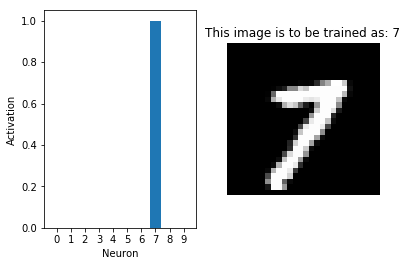

In [4]:
observe_image_number = int(input('Choose training image number from 0 to 60,000: '))

ind = y_train[observe_image_number] 
string = str('This image is to be trained as: '+str(ind))

plot_image_and_intended_activation(x_train[observe_image_number], y_oh_train[observe_image_number], string) 

# What went into preparing the data set?
Preparing a data is easily the most arduous task of developing AI.  Datasets must be carefully curated and cleaned.
An important data requirement is that there must be about the same number of samples of each digit.  If there are not an equal number, data scientists generate more data that is "similar" to existing data.<br>

Data set preparation issues cause many errors in AI.  <br>

This dataset like any other is extensively curated and cleaned.  
Can we directly observe some of this data cleaning?
Let's see what the average digit looks like in each category.

Let's take a look at the average digits of the data set.

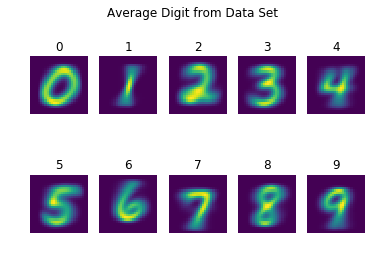

In [5]:
for select_digit in range(num_classes):   # select digit
    label = np.zeros((10))   
    label[select_digit] = 1   # create label like it is found in the data set
    index_of_select_digit = np.where(y_train == select_digit)[0]

    mean_image_of_select_digit = (np.mean(x_train[index_of_select_digit,:,:,0], axis=0))  # average all selected digit 
    plt.subplot(2, 5, select_digit+1)  #right side of figure
    plt.imshow(np.reshape(mean_image_of_select_digit, (28,28)), extent=[0, 1, 0, 1]) #show image as 28x28
    plt.axis('off') 
    plt.title(select_digit) 
plt.suptitle('Average Digit from Data Set')    
plt.show()

The average data for each digit label looks like a prototypical digit, which is reassuring. But note some oddities – certain digits are higher than others. For example, 7 and 9 are lower than 6. Digits do not usually appear this way.

### What is going on?

It looks like the authors of this data set possibly used a function to normalize the image by the weight of its pixels. They may have averaged all the pixels for each image then centered the images at their center of mass. That could cause the 7s and 9s to be higher and 6s to be lower, because their pixel-wise "center of mass" is different.

Can these subtle changes affect recognition? We are now almost ready to train the network and see.

But one more step remains. After the data set is cleaned, it must be sorted randomly and digits presented in fixed frequencies otherwise known as independent and identically distributed (IID) random variables. If the data set is not sorted in this manner the network will suffer from catastrophic interference (i.e. forget some of the digits during training).

Now let's train the simple single-layer neural network on the MNIST digit recognition data set. The network accepts the data set images of size 28x28 and has 10 outputs each representing the digits 1 through 9 and 0 and flattens them.

- We will train this single-layer network using several methods.
- We will use the OM illumination technology to see what we can understand about how the networks are recognizing the digits.

# Classifier 1 - SVM (Support Vector Machine) using scikit-learn

## Training

We skip every other training sample to reduce training time to approximately one minute. Feel free to experiment with the training if you registered for Optimizing Mind tools earlier in this lab. You may register anytime

In [6]:
from sklearn.svm import LinearSVC
import time

start = time.time()
svm = LinearSVC().fit(flat_x_train[::2], y_train[::2])  # ::2 skips every other training example
end = time.time()
print('Score on training',svm.score(flat_x_train, y_train))
print('Training time = {0} sec'.format(int(end-start)))

#Predict Output
yhat_test_svm = svm.predict(np.reshape(x_test_orig,(x_test_orig.shape[0],784)))
#Get weights
svm_weights = svm.coef_.T 

Score on training 0.8300833333333333
Training time = 67 sec


## SVM recognition of individual images

Let’s explicitly do recognition on images one at a time. This is commonly abstracted away in within the predict function of learning tools but is the fundamental processing of all feedforward neural networks.

We then pick the activation of the most positive neuron which represents what the network has decided.

Choose test image number from 0 to 10,000: 9999

         AI thinks this is a 6
         (Test set marked it as a 6)


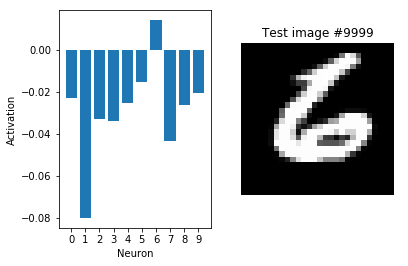

In [8]:
test_image_number = int(input('Choose test image number from 0 to 10,000: '))

test_image = x_test[test_image_number,:]
net_input = np.reshape(test_image[:,:,0],(784))  #reshape into 784 vector
NN_recognition = np.dot(net_input, svm_weights)  #calculate neuron activations based on y=wx
ind = np.unravel_index(np.argmax(NN_recognition, axis=None), NN_recognition.shape)  #find most active node

string=str('Test image #'+str(test_image_number))
print('')
print('         AI thinks this is a {0}'.format(ind[0]))
print('         (Test set marked it as a {0})'.format(y_test[test_image_number]))
plot_image_and_intended_activation(test_image, NN_recognition, string)

## Calculating Accuracy

Now let's test how well the network "recognizes overall" by calculating its accuracy. In the code below, we run through the entire test set and count how many results are correct to get accuracy.

In [9]:
num_correct = 0
for x in range(x_test.shape[0]):
       if yhat_test_svm[x] == y_test[x]: # we use the predict function of the learning library
              num_correct += 1
print('Percent Accuracy on Test Set = ',(100 * num_correct) / x_test.shape[0])

Percent Accuracy on Test Set =  82.93


The accuracy is relatively high. This must be a good network, right? The higher the accuracy, the less errors the network will do in real life, right?

Not so fast! This is a common mistake that even experts make. Let’s see what the network is actually looking for...

# Optimizing Mind Explanation

Next, let's reveal the ideal patterns the network is looking for using Optimizing Mind's technology.

In [10]:
import OM_Tools

if OM_Tools.User.logged_in():
    ret = OM_Tools.User.weights_to_patterns(svm_weights)
    if ret.return_code == 'Success':
        print('Optimizing Mind API completed successfully.')
        svm_patterns = ret.output
    else:
        print('{0}: {1}'.format(ret.return_code, ret.error))
else:
    svm_patterns = np.load('patterns/svm_patterns.npy')
    print('Static patterns loaded successfully.')

Static patterns loaded successfully.


We prove that these are the ideal patterns because when we run them through the network as inputs, they activate only the associated digit and no others. The network reports 100% for each of these patterns.

_Note that if you signed in with Optimizing Mind earlier in this lab, you will see a 100% accurate representation of what your network is looking for here. If not, you will have approximate static patterns for a network which will be similar to the one you trained (but not exactly the same)._

Scroll down to see all patterns.


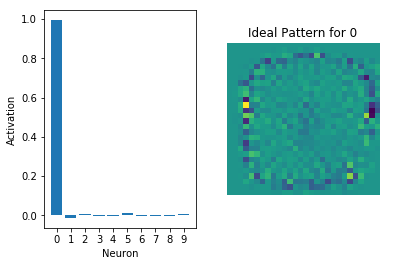

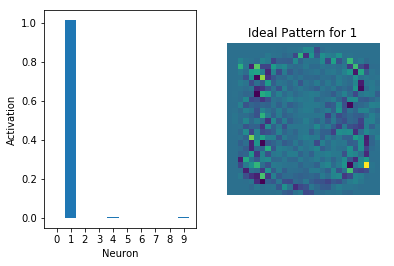

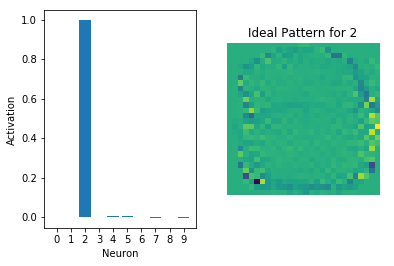

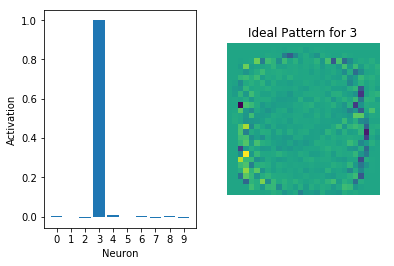

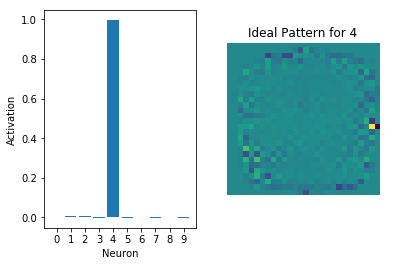

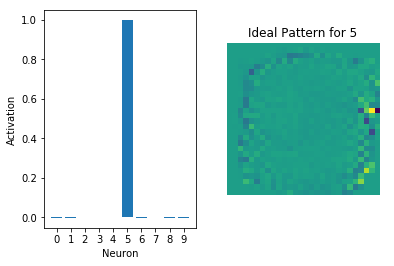

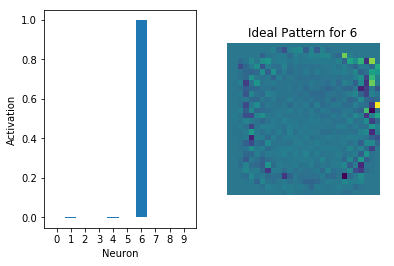

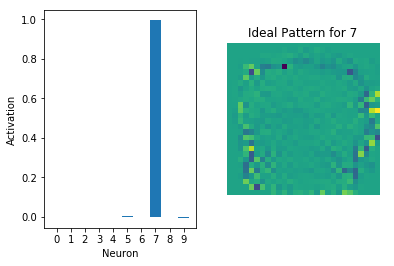

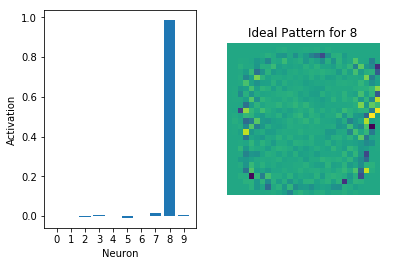

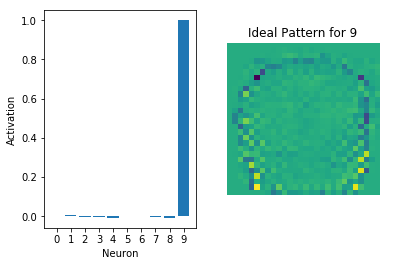

In [11]:
print('Scroll down to see all patterns.')
for digit in range(0,10):
    test_image = svm_patterns[digit,:]   # image chosen from the test set based on image number
    NN_recognition = np.dot(svm_weights.T, test_image)  #calculate neuron activations
    string=str('Ideal Pattern for {0}'.format(digit))

    plot_image_and_intended_activation(test_image, NN_recognition,string)

### What is going on?

The network learned from the data set that these pixels are most predictive patterns for the numbers. However, these patterns are very different from digits.

Some of these results may be due to the data cleaning that set certain numerals at certain heights.

### Old Military AI story

There is a story about old military exploration of neural networks.  They trained their AI to distinguish between friendly tanks and enemy tanks. The AI worked well for the test and training set, but completely failed when when they deployed the AI in the field.

They pondered the reason until someone realized that all of the pictures of enemy tanks were taken on a cloudy day while all of the friendly tanks were taken on a sunny day. So what did the network learn?

The network learned to distinguish between cloudy and sunny days! The learning algorithm latched onto a systematic feature unintentionally introduced into the data set — in this case, the sky and clouds.

### This is not a solved problem!

As data becomes more complex, there are even more possibilities of systematic errors. They are impossible to guess, so the only way is to observe the patterns the AI is looking for and evaluate if those patterns make sense. In such cases, “accuracy” gives false expectations and having true explainability is essential.

Such unintended systematic features can occur in many shapes and forms. In our case, they are pixels in certain unusual locations associated with certain digits.

There are several other examples of datasets that are known to be faulty and some are listed here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2529479/#S3title. In the early days of facial recognition, for instance, facial datasets could give accurate results even with the faces completely blotted out! The Essex facial dataset introduces a high classification accuracy of 97% when using the non-facial areas of the 42×100 top left pixels of each image.


# Creating adversarial examples for SVM

Once we know the patterns the network is looking for, we can use this information to easily create adversarial examples. We simply pick the strongest pixels and present this to the network.

Scroll down to see all patterns.


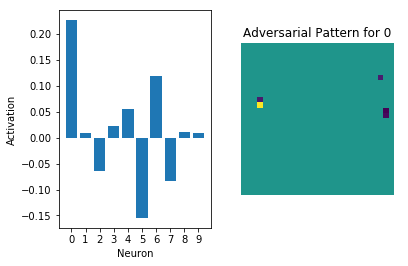

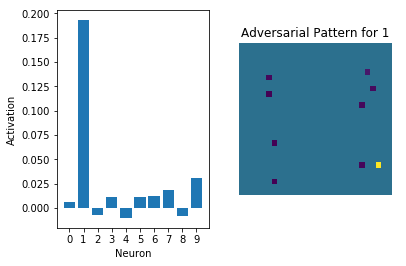

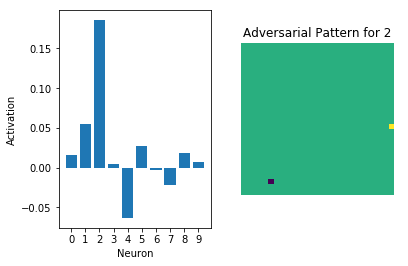

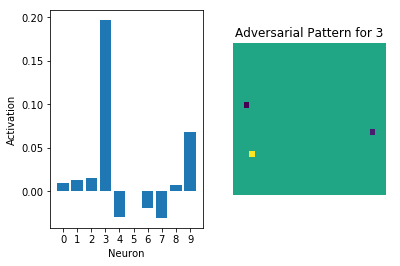

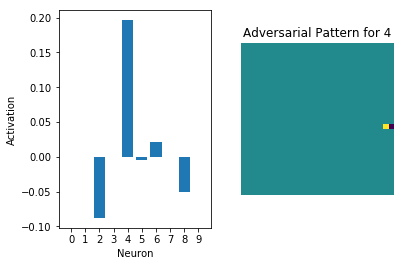

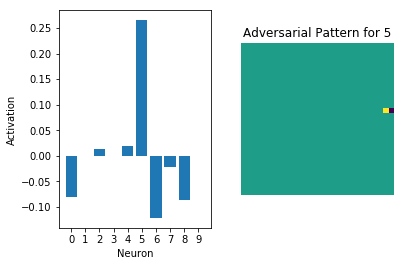

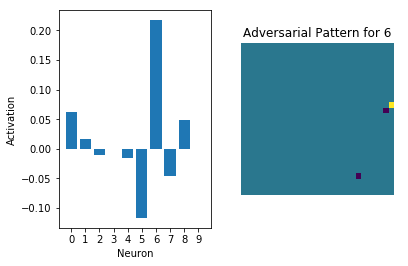

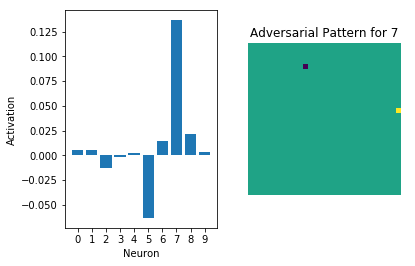

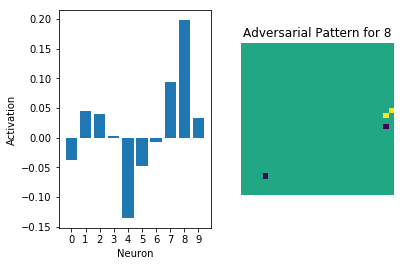

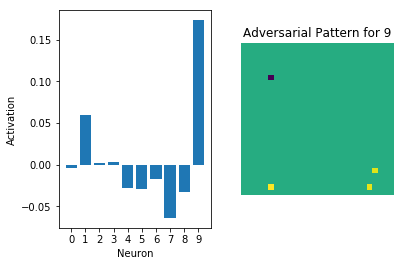

In [12]:
percent = 20/100  # Choose the strongest x% pixels  
edged = 1 - percent

print('Scroll down to see all patterns.')
for digit in range(0,10):
    top = np.max(svm_patterns[digit,:])  # find max and min pixels in image
    bottom = np.min(svm_patterns[digit,:])
    adversarial_image = (svm_patterns[digit,:] * (svm_patterns[digit,:] > (edged * top)) 
                         + svm_patterns[digit,:] * (svm_patterns[digit,:] < (edged * bottom)))  # include pixels within range of max  
        
    NN_recognition = np.dot(svm_weights.T,adversarial_image)  #calculate neuron activations
    
    string = str('Adversarial Pattern for {}'.format(digit))
    plot_image_and_intended_activation(adversarial_image, NN_recognition,string)

These patterns look nothing like digits! Yet the network, having learned these unexpected patterns, treats them like digits nonetheless. If this AI is released as a digit detector in the real world, it will surely make mistakes.

## What is going on?

There appears to be systematic noise in the data set.  

For instance, if a certain pixel is on only for a specific digit in the data set (e.g. the top right corner of the image) it can become highly predictive for that digit. However, these specific pixels would only be predictive in that specific data set.

Such errors contribute to the colorful history of problems in datasets, like the early facial recognition data set having enough differences in the background that the faces themselves do not matter.

The fact that some digits are artificially lower in the image likely also contributes to systematic noise: pixels not within the digits are overly predictive. A similar error would be a network learning to recognize a fox by looking at snow instead of the animal, similar to the clouds above the tank example.

# How can this be fixed?

As a general rule, adding more data from various sources to the training should help. However even then, there is no guarantee that the data is free from systematic noise (e.g. an unintended single pixel in the corner being very predictive in the training set). Fortunately, the explanation not only reveals insights about what is in the network, but also the data set.

Optimizing Mind has a method to train these types of networks directly. See the MNIST summary section to learn more.

# LIME on SVM

We discussed that accuracy will not reveal what patterns the network looks for and good accuracy may not correlate to recognition using real world patterns. Now let's see how other methods of explainability reveal patterns the network learned. We will evaluate the same network with LIME which works by randomly modifying input images to determine which patterns the network is more sensitive to.  

A great primer on LIME (Local Interpretable Model-Agnostic Explanations) and the need for explainability can be found here: https://www.youtube.com/watch?v=hUnRCxnydCc

For the LIME part of the demonstration we will use the LIME libraries and scikit-learn.

We will follow the flow as described in https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20MNIST%20and%20RF.ipynb (using the same LinearSVC as we do to train in our example).

We will use a pipeline for processing the images as LIME requires images to be flattened and in RGB format. Then we ask, does running LIME on the same model reveal the same problems we found earlier?

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from skimage.color import gray2rgb,rgb2gray, label2rgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

class PipeStep(BaseEstimator, TransformerMixin):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    *** This should be linear, just returning the values
    """
    def __init__(self, step_func):
        self._step_func = step_func
        
    def fit(self, *args):
        return self
    
    def transform(self, X):
        return self._step_func(X)

In [14]:
img_preproc = PipeStep(lambda img_list: rgb2gray(img_list.reshape(img_list.shape[0], -1)))
svc = CalibratedClassifierCV(LinearSVC())
svc_pipe = Pipeline([
    ('Gray Flatten Image', img_preproc),
    ('SVM', svc)
    ])

First, we have to retrain the same data in grayscale RGB format. Training will take about 90 seconds or more. Might be a good time to get up and stretch.

In [15]:
import time 

start = time.time()
svc_pipe.fit(x_train[::2], y_train[::2])  # ::2 skips every other training example
end = time.time()
print('Training time = {0} sec'.format(int(end-start)))

Training time = 193 sec


In [16]:
yhat_test_svc = svc_pipe.predict(x_test)

In [17]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

Choose test image number from 0 to 10,000: 100


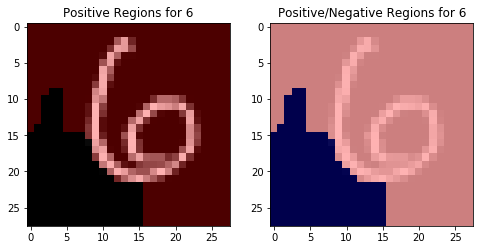

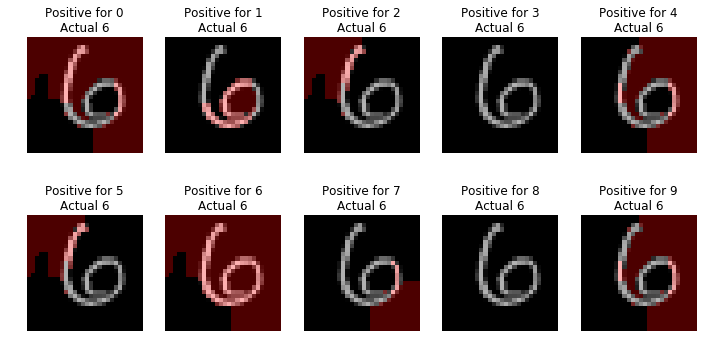

In [19]:
img_idx = int(input('Choose test image number from 0 to 10,000: '))

explanation = explainer.explain_instance(x_test[img_idx], 
                                         classifier_fn = svc_pipe.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)


temp, mask = explanation.get_image_and_mask(y_test[img_idx], positive_only=True, 
                                            num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[img_idx]))
temp, mask = explanation.get_image_and_mask(y_test[img_idx], positive_only=False, 
                                            num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[img_idx]))

# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask, x_test[img_idx], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[img_idx]))
    c_ax.axis('off')

Methods like LIME vary inputs and see what the network is more sensitive to. This is based on trial and error and may miss certain variations of inputs if the right variations are not programmed in to try.

Optimizing Mind technology avoids guessing. Optimizing Mind uses a unique, direct, and efficient solution that reveals the ground-truth, and provides the patterns which the network is actually looking for.

# Classifier 2 - Single-layer perceptron using scikit-learn

## Training

In [20]:
from sklearn.neural_network import MLPClassifier
import time

mlp = MLPClassifier(hidden_layer_sizes=()) # use single layer training 
start = time.time()
mlp.fit(flat_x_train, y_train)
end = time.time()
print('Score on training',mlp.score(flat_x_train, y_train))
print('Training time = {0} sec'.format(int(end-start)))

#Predict Output
yhat_test_mlp = mlp.predict(np.reshape(x_test_orig, (x_test_orig.shape[0],784)))
#Get weights
mlp_weights = mlp.coefs_[0].T 

Score on training 0.8983166666666667
Training time = 8 sec


## Single-layer perceptron recognition of individual images

Choose test number from 0 to 10,000: 100
         AI thinks this is a 6
         (Test set marked it as a 6)


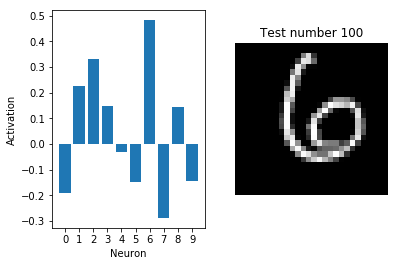

In [21]:
test_image_number = int(input('Choose test number from 0 to 10,000: '))

test_image = x_test[test_image_number,:] 
net_input = np.reshape(test_image[:,:,0], (784))  #reshape into 784 vector
NN_recognition = np.dot(net_input.T, mlp_weights.T)  #calculate neuron activations based on y=wx
ind = np.unravel_index(np.argmax(NN_recognition, axis=None), NN_recognition.shape)  #find most active node

string=str('Test number '+str(test_image_number)) 
print('         AI thinks this is a {0}'.format(ind[0]))
print('         (Test set marked it as a {0})'.format(y_test[test_image_number]))
plot_image_and_intended_activation(test_image, NN_recognition, string)

## Calculating accuracy

In [22]:
num_correct = 0
for x in range(x_test.shape[0]):
       if yhat_test_mlp[x] == y_test[x]: # we use the predict function of the learning library
              num_correct += 1
print('Percent Accuracy on Test Set = ', (100 * num_correct) / x_test.shape[0])

Percent Accuracy on Test Set =  88.55


Let's also look at the confusion matrix which tells us how many errors of different types occur.

Entries on the diagonal are correct recognitions. Entries above the diagonals are false positives, and the ones on the bottom are false negatives. For more information, see: https://en.wikipedia.org/wiki/Confusion_matrix

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, yhat_test_mlp)

array([[ 866,    0,   19,    2,    1,   43,   33,    7,    7,    2],
       [   0, 1119,    8,    1,    0,    2,    3,    2,    0,    0],
       [   1,   20,  939,    9,    6,    8,   14,   10,   21,    4],
       [   2,    9,   49,  810,    1,   92,    4,   13,   20,   10],
       [   0,    5,   17,    1,  885,    2,   15,   10,    7,   40],
       [   3,    5,    8,   21,    8,  779,   32,    3,   26,    7],
       [   3,    3,    6,    0,    6,   18,  920,    1,    1,    0],
       [   0,    8,   30,    9,    7,    3,    1,  916,    3,   51],
       [   3,   51,   26,   23,   12,   91,   24,   16,  712,   16],
       [   2,    8,    2,    6,   34,   20,    0,   22,    6,  909]])

Let’s see what the network is looking for.

# Optimizing Mind Explanation

Next, let's reveal the ideal patterns the network is looking for using Optimizing Mind's technology.  

_Note that if you signed in with Optimizing Mind and use our tool you will have a 100% accurate display. If not, you will have approximate static patterns of a network which should be similar to the one you trained (but not exact)._

In [24]:
import OM_Tools

if OM_Tools.User.logged_in():
    ret=OM_Tools.User.weights_to_patterns(mlp_weights.T)
    if ret.return_code == 'Success':
        print('Optimizing Mind API completed successfully.')
        mlp_patterns = ret.output
    else:
        print('{0}: {1}'.format(ret.return_code,ret.error))
else:
    mlp_patterns = np.load('patterns/mlp_patterns.npy')
    print('Static patterns loaded successfully.')


Static patterns loaded successfully.


Scroll down to see all patterns.


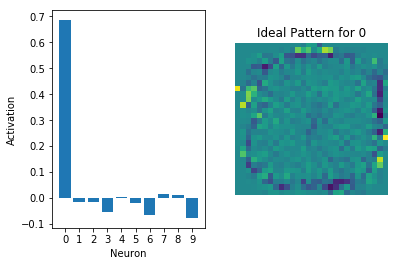

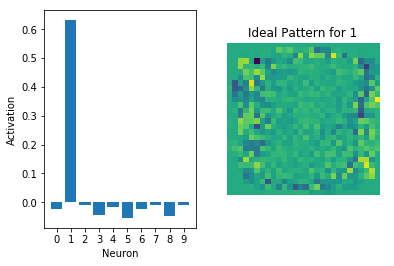

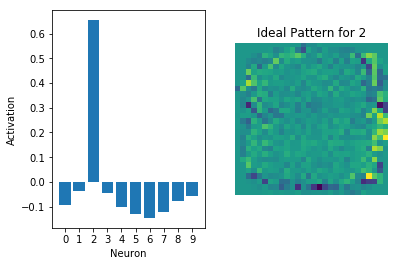

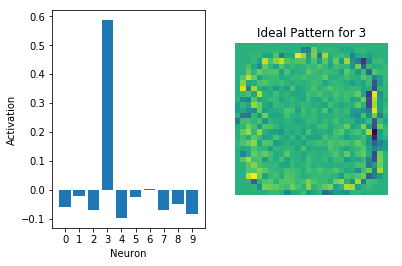

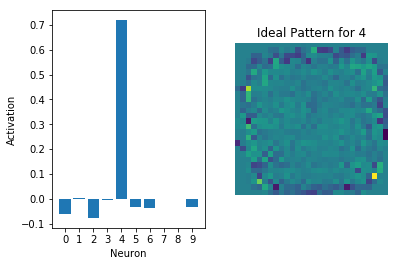

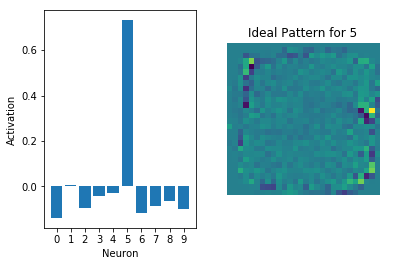

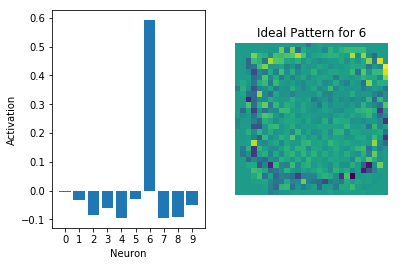

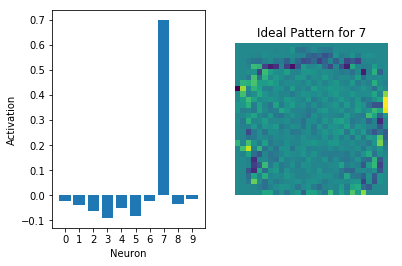

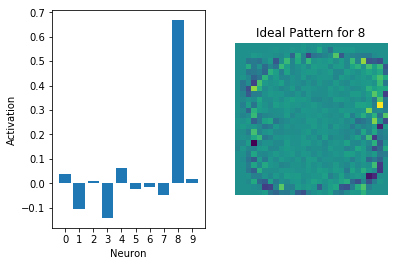

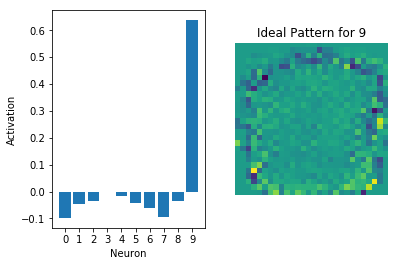

In [25]:
print('Scroll down to see all patterns.')
for digit in range(0,10):
    test_image = mlp_patterns[digit,:]
    NN_recognition = np.dot(mlp_weights, test_image)  #calculate neuron activations
    string=str('Ideal Pattern for {}'.format(digit))

    plot_image_and_intended_activation(test_image, NN_recognition,string)

# Creating perceptron adversarial examples

Scroll down to see all patterns.


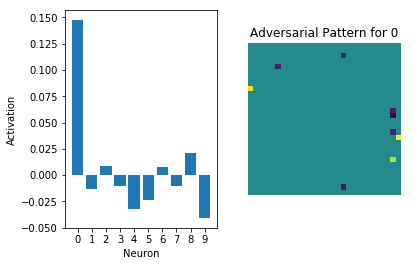

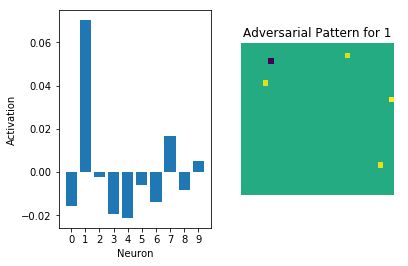

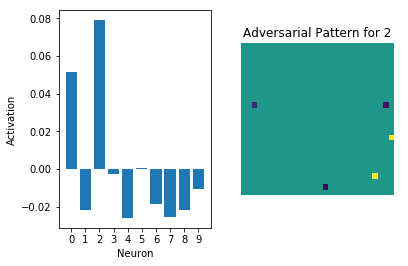

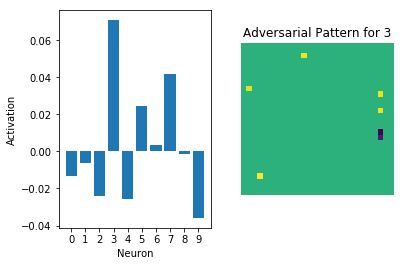

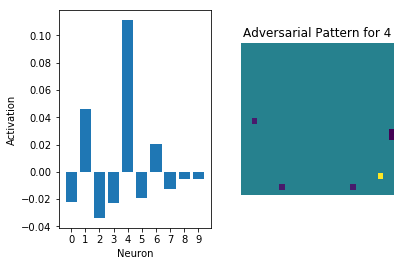

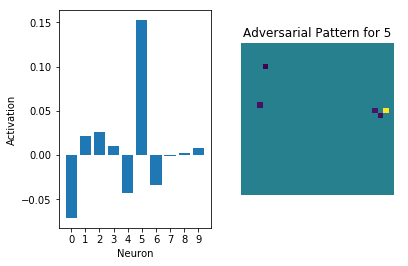

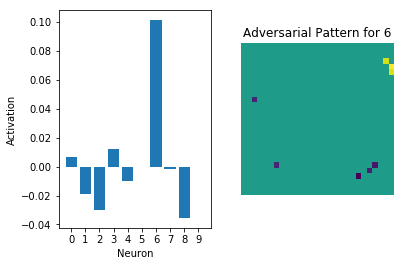

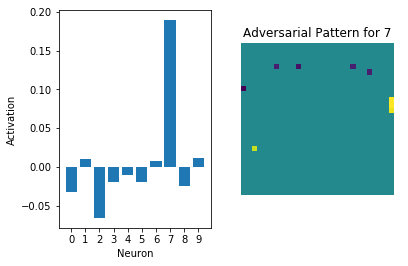

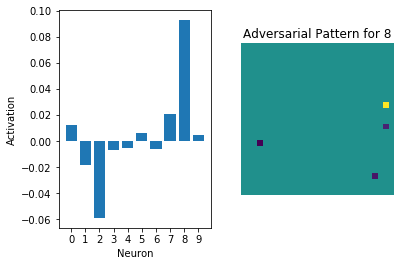

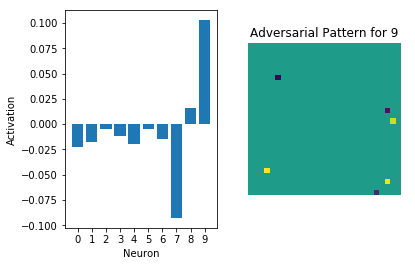

In [26]:
percent = 20/100  # Choose the strongest x% pixels  
edged = 1 - percent

print('Scroll down to see all patterns.')
for digit in range(0,10):
    top = np.max(mlp_patterns[digit,:])  # find max and min pixels in image
    bottom = np.min(mlp_patterns[digit,:])
    adversarial_image = (mlp_patterns[digit,:] * (mlp_patterns[digit,:] > (edged * top)) 
                         + mlp_patterns[digit,:] * (mlp_patterns[digit,:] < (edged * bottom)))  # include pixels within range of max  
    NN_recognition = np.dot(mlp_weights, adversarial_image)  #calculate neuron activations

    string = str('Adversarial Pattern for {}'.format(digit))
    plot_image_and_intended_activation(adversarial_image, NN_recognition, string)

Both the SVM and perceptron examples show similar, odd adversarial patterns. Let's try another network...

# Classifier 3 - A neural network using Keras

## Training

In [27]:
from keras import Sequential
from keras.layers import Dense, Flatten, Lambda, InputLayer

keras = Sequential()
keras.add(InputLayer((28,28,3)))
keras.add(Lambda(lambda x: x[...,0]))
keras.add(Flatten())
keras.add(Dense(10, activation='softmax', use_bias=False))
keras.compile('SGD', 'categorical_crossentropy', metrics=['accuracy'])
keras.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7840      
Total params: 7,840
Trainable params: 7,840
Non-trainable params: 0
_________________________________________________________________


In [28]:
keras.fit(x_train, y_oh_train, epochs=7,)

Epoch 1/7
60000/60000 [==============================] - 6s 101us/step - loss: 0.7751 - acc: 0.8133
Epoch 2/7
60000/60000 [==============================] - 5s 90us/step - loss: 0.4592 - acc: 0.8791
Epoch 3/7
60000/60000 [==============================] - 5s 90us/step - loss: 0.4067 - acc: 0.8903
Epoch 4/7
60000/60000 [==============================] - 5s 91us/step - loss: 0.3807 - acc: 0.8958
Epoch 5/7
60000/60000 [==============================] - 5s 90us/step - loss: 0.3643 - acc: 0.8994
Epoch 6/7
60000/60000 [==============================] - 5s 90us/step - loss: 0.3528 - acc: 0.9023
Epoch 7/7
60000/60000 [==============================] - 5s 90us/step - loss: 0.3441 - acc: 0.9045


In [29]:
keras_weights = keras.layers[-1].get_weights()[0]
yhat_test_keras = keras.predict_proba(x_test)


# Keras recognition of individual images

Choose test number from 0 to 10,000: 100
         AI thinks this is a 6
         (Test set marked it as a 6)


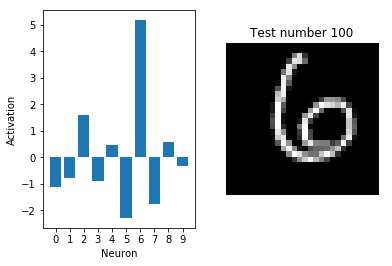

In [30]:
test_image_number = int(input('Choose test number from 0 to 10,000: '))

test_image = x_test[test_image_number,:] 
net_input = np.reshape(test_image[:,:,0], (784))  #reshape into 784 vector
NN_recognition = np.dot(keras_weights.T, net_input)  #calculate neuron activations based on y=wx
ind = np.unravel_index(np.argmax(NN_recognition, axis=None), NN_recognition.shape)  #find most active node

string=str('Test number '+str(test_image_number)) 
print('         AI thinks this is a {0}'.format(ind[0]))
print('         (Test set marked it as a {0})'.format(y_test[test_image_number]))
plot_image_and_intended_activation(test_image, NN_recognition, string)

# Calculating accuracy

In [31]:
num_correct = 0
for x in range(x_test.shape[0]):
    ind = np.argmax(yhat_test_keras[x])  # we use the predict function of the learning library
    if ind == y_test[x]: 
        num_correct += 1
print('Percent Accuracy on Test Set = ', (100 * num_correct) / (x_test.shape[0]))

Percent Accuracy on Test Set =  91.08


Let’s see what the network is looking for.

# Optimizing Mind Explanation

Next, let’s reveal the ideal patterns the network is looking for using Optimizing Mind’s technology.

_Note that if you signed in with Optimizing Mind and use our tool you will have a 100% accurate display. If not, you will have approximate static patterns of a network which should be similar to the one you trained (but not exact)._

In [32]:
import OM_Tools

if OM_Tools.User.logged_in():
    ret=OM_Tools.User.weights_to_patterns(keras_weights)
    if ret.return_code == 'Success':
        print('Optimizing Mind API completed successfully.')
        keras_patterns = ret.output
    else:
        print('{0}: {1}'.format(ret.return_code,ret.error))
else:
    keras_patterns = np.load('patterns/keras_patterns.npy')
    print('Static patterns loaded successfully.')


Static patterns loaded successfully.


Scroll down to see all patterns.


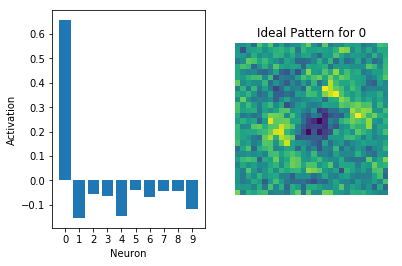

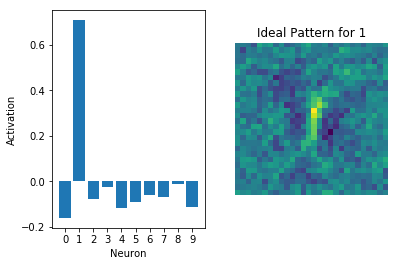

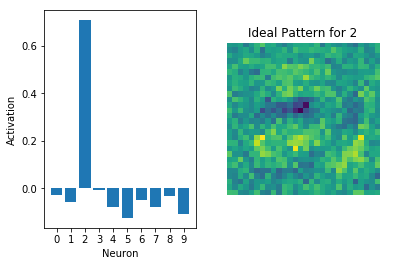

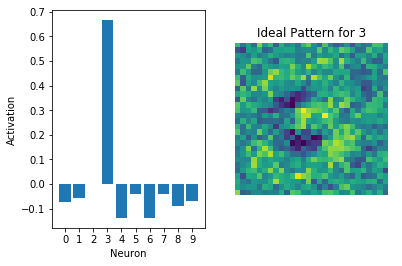

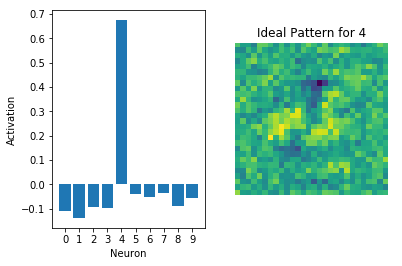

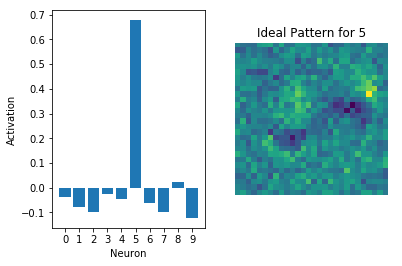

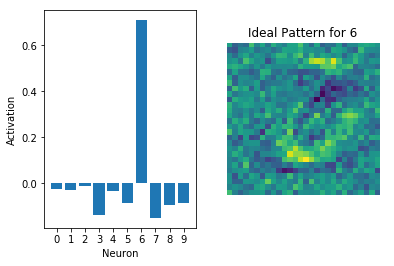

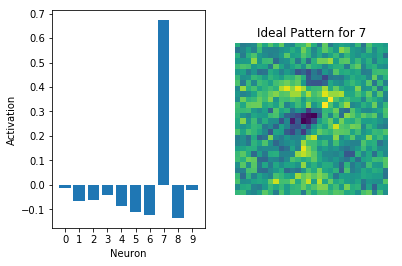

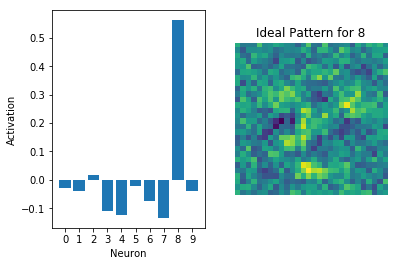

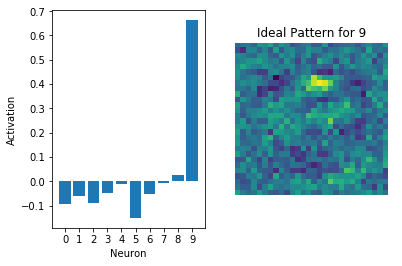

In [33]:
print('Scroll down to see all patterns.')
for digit in range(0,10):
    test_image = keras_patterns[digit,:] 
    display_image = np.stack([test_image.reshape(28,28)]*3, axis=-1)
    NN_recognition = np.dot(keras_weights.T, display_image[:,:,0].ravel())  #calculate neuron activations

    string=str('Ideal Pattern for {}'.format(digit))
    plot_image_and_intended_activation(display_image[:,:,0], NN_recognition, string)

# Creating adversarial examples for Keras

Scroll down to see all patterns.


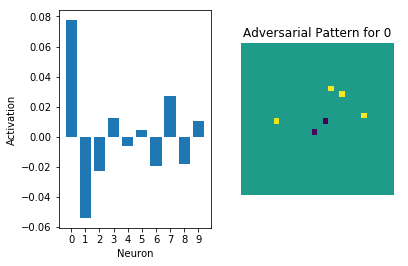

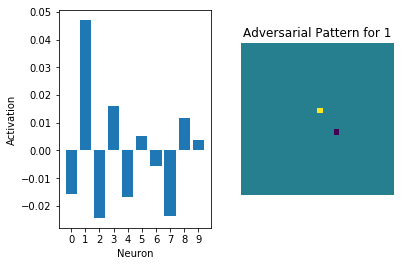

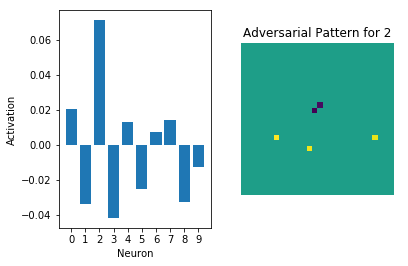

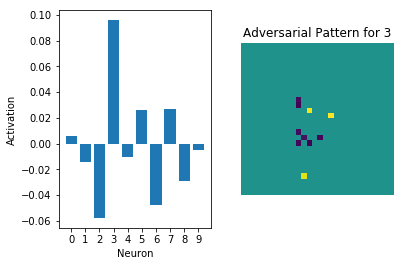

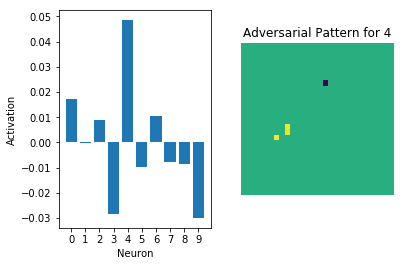

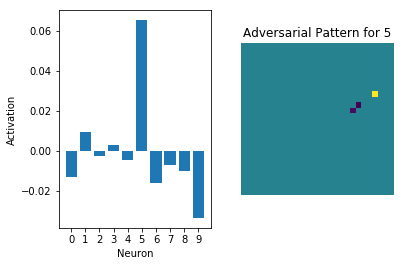

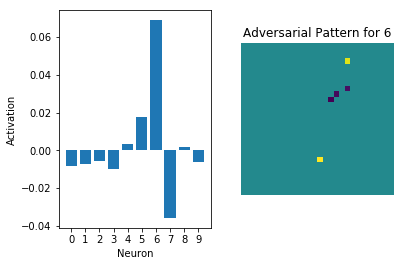

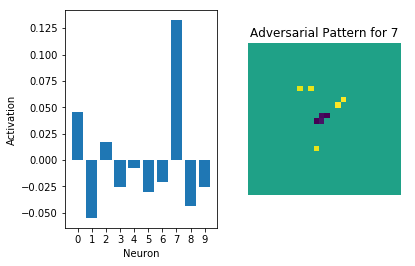

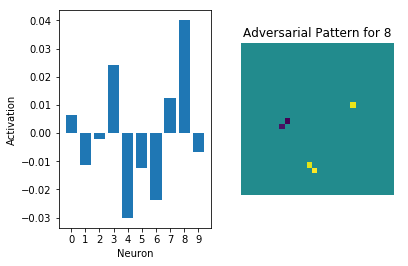

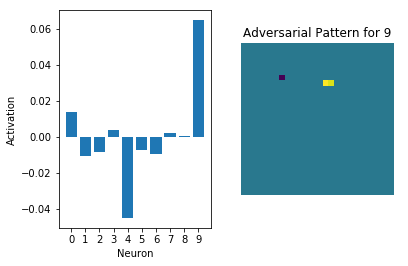

In [34]:
percent = 10/100  # Choose the strongest x% pixels  
edged = 1 - percent

print('Scroll down to see all patterns.')
for digit in range (0,10):
    top = np.max(keras_patterns[digit,:])  # find max and min pixels in image
    bottom = np.min(keras_patterns[digit,:])
    adversarial_image = (keras_patterns[digit,:] * (keras_patterns[digit,:] > (edged * top))
                         + keras_patterns[digit,:] * (keras_patterns[digit,:] < (edged * bottom)))  # include pixels within range of max  

    display_image = np.stack([adversarial_image.reshape(28,28)]*3, axis=-1)
    NN_recognition = np.dot(keras_weights.T, display_image[:,:,0].ravel())  #calculate neuron activations

    string=str('Adversarial Pattern for {}'.format(digit))
    plot_image_and_intended_activation(display_image[:,:,0],NN_recognition, string)

This method does better that the previous two methods. For certain digits, it appears to be looking for expected digit patterns familiar to humans.

# MNIST Summary

Below, we compare all 3 models we trained on each digit using the Optimizing Mind Illumination tool.

Scroll down to see all patterns.


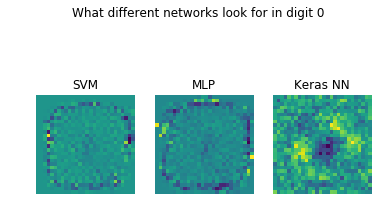

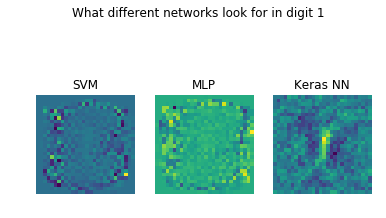

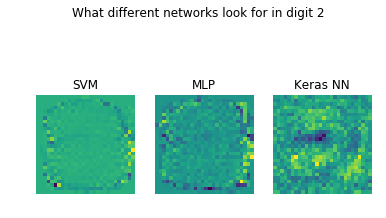

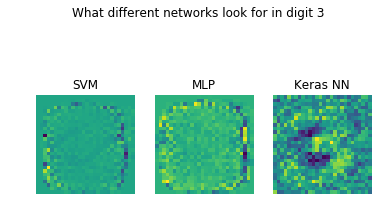

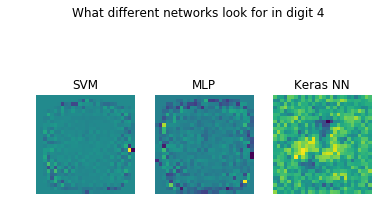

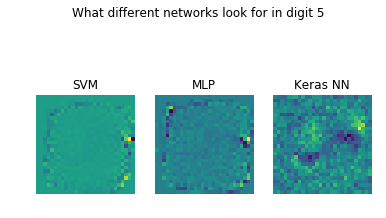

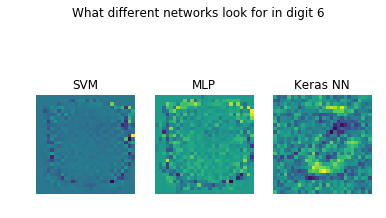

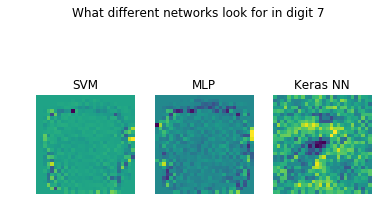

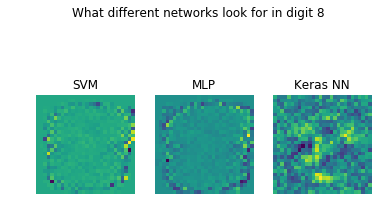

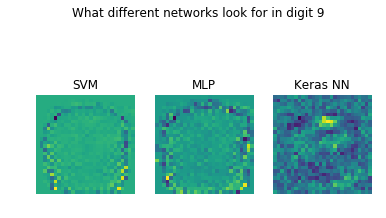

In [35]:
print('Scroll down to see all patterns.')
for digit in range(0,10):
    plt.subplot(1,3,1)  #organize all sub images into one figure
    plt.imshow(np.reshape(svm_patterns[digit,:],(28,28)), extent=[0, 1, 0, 1]) #plot the pattern
    plt.axis('off') 
    
    plt.title('SVM') 
    plt.subplot(1,3,2)  #organize all sub images into one figure
    plt.imshow(np.reshape(mlp_patterns[digit,:],(28,28)), extent=[0, 1, 0, 1]) #plot the pattern
    plt.axis('off') 
    plt.title('MLP') 
    plt.subplot(1,3,3)  #organize all sub images into one figure
    plt.imshow(np.reshape(keras_patterns[digit,:],(28,28)), extent=[0, 1, 0, 1]) #plot the pattern
    plt.axis('off') 
    plt.title('Keras NN') 
    
    string = str('What different networks look for in digit {}'.format(digit))
    plt.suptitle(string)    
    plt.show()

Different models process digits differently, sometimes relying on data artifacts instead of sensible digits. The Keras library learning did well compared to the SVM and perceptron library methods in learning sensible patterns.

However, even the Keras network was not complete. It produced sensible patterns for digits 0 and 1 but not digits 5 and 4.

### More explainability

We revealed the patterns the network is looking for. Using OM technology it is also possible to reveal which inputs are most important for any decision. This additional functionality is demonstrated in our video along with OM’s method of learning.

### Optimizing Mind Learning based on expected patterns

Being aware of potential adversarial examples and problems in our data set helps create better datasets, learning functions, and guides us on how to limit the function of AI to scenarios that make sense.
There is also a way to train the AI on expected patterns avoiding the adversarial patterns. In addition, this avoids some of the difficulties of feedforward learning. We offer all of these solutions to our customers. See more in our video: https://www.youtube.com/watch?v=vKf0WnYEjrU

# Beyond the single layer

The method we use derives the patterns internally from learned network weights and can be used for any type of feedforward neural network.

This can be applied to deep and convolutional neural networks. We briefly show a sample of recognition of a ResNet deep network.

Using the following image, the AI performed recognition below:

<img src="img/test_image2.png" width="500px" />

The recognition of the scene includes a person and a car (categories 11 and 13, respectively).

<img src="img/pic-colored.png" width="500px" />

This is derived from the output of the top layer:

<img src="img/334_out2.png" width="700px" />

We want a more detailed explanation and understanding of what it really takes to recognize a person. To do so, we choose a component representing a person and her location.

We label the image as a person by making only image 11 of the output active. We can then ask, what is expected for a person that looks like this?

<img src="img/labeled_Picture2.png" width="700px" />

We can see which patterns the network is looking for in the 512 input images of that layer.

<img src="img/334_pos_input_person_cropped.png" width="900px" />

We can also see which patterns the network is looking for in the 4096 input images of the layer below.

<img src="img/4096layer.png" width="900px" />

Looks like having another person nearby (but only a certain distance) helps with the recognition at that layer.

We can use this approach both in deep and convolutional neural networks.

At Optimizing Mind, we are helping companies design their AI with better understanding: increasing confidence and decreasing mishaps. Similarly, we are assisting regulators and their customers to have the ability to get insights and trust for the AI they are looking to approve.

# Feedback

Thank you working through this lab. How did we do? Please answer this short questionnaire:

In [36]:
import OM_Tools
from IPython.display import IFrame

email = OM_Tools.User.get_email() if OM_Tools.User.logged_in() else ''
IFrame(src='https://optimizingmind.com/lab-feedback/?email=' + email, width='800px', height='700px')

If you want to learn more, contact us at info@optimizingmind.com and visit our website: https://optimizingmind.com

<img src="img/clear_blue_logo.png" width="400px" />